In [ ]:
# MPT=Model portfolio theory
# Use machine learning to predict the best wi of a portfolio in order to increase the sharpe ratio of the overall port
# SR=(Port rtrn-rf)/SDport
# STEPS: 1)MPT and calc efficient frontiers, 2)Calc sharpe Ratios, 3)ML:Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter #change date format
import seaborn as sns #High quality charts
import talib #Calculate RSI ans SMA
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF factor-> How inflated the variance of the coefficient is. VIF>2.5
from scipy import stats #Calculate statistics
from sklearn.tree import DecisionTreeRegressor #Model the trees
from sklearn.tree import export_graphviz #See Tree chart
import quandl #API to importa finance data:
    #1) quandl.save_key("GAx6yHsvUnoL7LM9yHDi")
    #2) quandl.read_key()
    #3) print(quandl.ApiConfig.api_key)
    #4) quandl.ApiConfig.verify_ssl = False
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from pprint import pprint#print the grid parameter

<b> Variable declaration <b>

In [2]:
input_path= 'C:\\Users\\ccorral\\OneDrive - ACCIONA S.A\\Desktop\\PythonData\\'
file_name=''
output_path= 'C:\\Users\\ccorral\\OneDrive - ACCIONA S.A\\Desktop\\PythonData\\'

<b> Import data from QUANDL API <b>

In [4]:
quandl.save_key("GAx6yHsvUnoL7LM9yHDi")
print(quandl.ApiConfig.api_key)
quandl.ApiConfig.verify_ssl = False
print(quandl.ApiConfig.api_version)

GAx6yHsvUnoL7LM9yHDi
None


In [5]:
df_EOD_AAPL = quandl.get('EOD/AAPL')
df_EOD_MSFT = quandl.get('EOD/MSFT')
df_EOD_HD = quandl.get('EOD/HD')
#data = quandl.get('NSE/OIL')
#GDP = quandl.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31") #collapse='monthly'

C:\Users\ccorral\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\ccorral\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\Users\ccorral\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [6]:
#When you finish uploading data reconect the verification ssl
quandl.ApiConfig.verify_ssl = True

In [7]:
#print(df_EOD_HD.tail())
#print(df_EOD_HD.describe())
#print(df_EOD_HD.columns)
print(df_EOD_HD.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1090 entries, 2013-09-03 to 2017-12-28
Data columns (total 12 columns):
Open          1090 non-null float64
High          1090 non-null float64
Low           1090 non-null float64
Close         1090 non-null float64
Volume        1090 non-null float64
Dividend      1090 non-null float64
Split         1090 non-null float64
Adj_Open      1090 non-null float64
Adj_High      1090 non-null float64
Adj_Low       1090 non-null float64
Adj_Close     1090 non-null float64
Adj_Volume    1090 non-null float64
dtypes: float64(12)
memory usage: 110.7 KB
None


In [8]:
#Join al the adj_close price of all the datasets
df_stocks=pd.concat([df_EOD_AAPL['Adj_Close'],df_EOD_MSFT['Adj_Close'],df_EOD_HD['Adj_Close']],axis=1).dropna()
df_stocks.columns=['AAPL','MSFT','HD']
#df_stocks=df_EOD_AAPL['Adj_Close'].merge(df_EOD_HD['Adj_Close'],on=Index,how='left').fillna(0)

In [9]:
print(df_stocks.head())
print(df_stocks.describe())

                 AAPL       MSFT         HD
Date                                       
2013-09-03  15.476472  27.456741  62.787375
2013-09-04  15.796753  26.866783  62.991286
2013-09-05  15.688388  26.901233  62.014215
2013-09-06  15.781833  26.829749  61.767824
2013-09-09  16.033661  27.262960  62.515495
              AAPL         MSFT           HD
count  1090.000000  1090.000000  1090.000000
mean     26.373196    48.343758   105.533892
std       6.616455    13.355366    27.767769
min      14.258197    26.829749    61.767824
25%      22.201030    38.426534    79.919768
50%      25.789823    45.713932   107.646320
75%      29.362853    57.007230   122.731563
max      42.440845    83.522533   177.032785


<b> MODERN PORTFOLIO THEORY. EFFICIENT FRONTIER <b>

<b>Calculate returns<b>

In [10]:
df_rtrns_d=df_stocks.pct_change()#Daily returns
df_stocks_m=df_stocks.resample('BMS').first()#BMS=business month start
df_rtrns_m=df_stocks_m.pct_change().dropna()#Monthly returns
print(df_rtrns_d.describe())
print(df_rtrns_m.describe())

              AAPL         MSFT           HD
count  1089.000000  1089.000000  1089.000000
mean      0.001000     0.001103     0.001008
std       0.014285     0.013659     0.010822
min      -0.079927    -0.092534    -0.047768
25%      -0.005857    -0.005558    -0.004578
50%       0.000766     0.000503     0.000973
75%       0.008594     0.007690     0.006973
max       0.081982     0.104522     0.055509
            AAPL       MSFT         HD
count  51.000000  51.000000  51.000000
mean    0.021398   0.023249   0.020544
std     0.064206   0.061543   0.047696
min    -0.148650  -0.117194  -0.084492
25%    -0.026813  -0.012953  -0.018703
50%     0.028623   0.024230   0.012183
75%     0.067496   0.056980   0.051395
max     0.108480   0.194867   0.148840


<b>Calculate covariance<b>

In [11]:
#cov for each monthly period 
dc_cov={} #IMPORTANT dictionary
for i in df_rtrns_m.index: #Para cada uno de los dias calcula la cov
    idx_rtrns_d=df_rtrns_d.index
    mask=(idx_rtrns_d.month==i.month)&(idx_rtrns_d.year==i.year) # Daily returns for each month&year
    dc_cov[i]=df_rtrns_d[mask].cov()
print(dc_cov[i]) #Last day cov

          AAPL      MSFT        HD
AAPL  0.000089  0.000040 -0.000021
MSFT  0.000040  0.000171 -0.000069
HD   -0.000021 -0.000069  0.000075


<b>Generating portfolio<b>

In [12]:
port_rtrns, port_wi,port_vol={},{},{} #create 3 dictionaries 
for date in sorted(dc_cov.keys()):
    cov=dc_cov[date]
    for portfolio in range(10000):#10000 portfolios por cada punto de tiempo(mes) formados por 3 compañías con wi aleatorios
        wi=np.random.random(3)#3 companies
        wi/=np.sum(wi) #Normalize to %
        
        returns=np.dot(wi,df_rtrns_m.loc[date]) #Multiply element-by-element and sums up monthly return and wi
        volatility=np.sqrt(np.dot(wi.T,np.dot(wi,cov)))#".T"=Transpose
       
        port_rtrns.setdefault(date,[]).append(returns)
        port_wi.setdefault(date,[]).append(wi)
        port_vol.setdefault(date,[]).append(volatility)
    

<function matplotlib.pyplot.show(*args, **kw)>

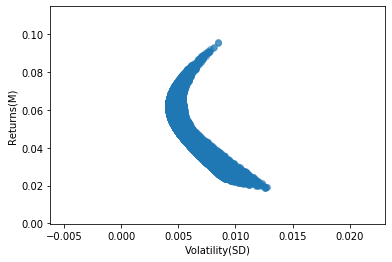

In [82]:
#Plot efficient frontier=>Optimal portfolios that offers the highest expected returns for a specific level of risk, If the securities have low cov the port will have lower SD
#Assumes Normal distribution of returns but are more Fat-tailed and leptokurtic(flatter) (Therory Lognormal price distribuion->Normal returns distributions)
#Investors are rational an d avoid risk when possible
#Investor don't influence the markets
#Investors have unlimited acceses to lending/borrowing moneay at risk-free interest rate.
date=sorted(dc_cov.keys())[-1] #Get latest date of available data
plt.scatter(x=port_vol[date],y=port_rtrns[date], alpha=0.5)
plt.xlabel('Volatility(SD)')
plt.ylabel('Returns(M)')
plt.show

<b>CALCULATE SHARPE RATIOS, TARGETS AND FEATURES<b>

<b> Calculate SR <b>

In [20]:
#SR=(Return-rf)/SD
rf=0
dc_SR,dc_max_SR_idxs={},{}
for date in port_rtrns.keys():
    for i, i_return in enumerate(port_rtrns[date]):#Enumerate allows to use the value an a counter
        volatility=port_vol[date][i]
        dc_SR.setdefault(date,[]).append((i_return-rf)/volatility)
    dc_max_SR_idxs[date]=np.argmax(dc_SR[date]) #Index of the max sharpe ratio portfolio por each day.
                                        #our target will be the wi of the max SR 

<b> Calculate Features and targets <b>

In [22]:
df_ewma_d=df_rtrns_d.ewm(span=30).mean()#Calculate the EWMA (Exponentialy Weighted Moving Average) using last 30d as the most important.
df_ewma_m=df_ewma_d.resample('BMS').first()#Resample for a monthly 
df_ewma_m=df_ewma_m.shift(1).dropna()#shift 1m fordward

In [23]:
s_target, df_features=[],[] #Targets=> Best portfolios wi using best SR, features=>ewma
for date, ewma in df_ewma_m.iterrows():
    best_idx=dc_max_SR_idxs[date]
    s_target.append(port_wi[date][best_idx])
    df_features.append(ewma)
s_target=np.array(s_target)
df_features=np.array(df_features)

In [24]:
print(dc_max_SR_idxs[date]) #Best SR for the last date

2331


<function matplotlib.pyplot.show(*args, **kw)>

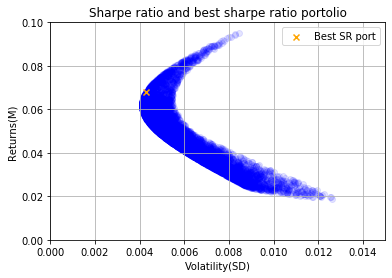

In [25]:
#Re-plot the efficince frontier to show the best SR port
date=sorted(dc_cov.keys())[-1] #Get latest date of available data
plt.scatter(x=port_vol[date],y=port_rtrns[date], alpha=0.1, color='blue')
best_idx=dc_max_SR_idxs[date]
plt.scatter(x=port_vol[date][best_idx],y=port_rtrns[date][best_idx], marker='x', color='orange',label='Best SR port')
plt.title('Sharpe ratio and best sharpe ratio portolio')
plt.xlabel('Volatility(SD)')
plt.ylabel('Returns(M)')
plt.xlim(0,0.015)
plt.ylim(0,0.10)
plt.legend()
plt.grid(True)
plt.show

<b> Calculate Features and targets <b>

In [27]:
#We would like to test if it is possible to predict the best portdolio wi using past volatility as feature
#Make train and test sets
train_size=int(0.80*s_target.shape[0])
#WARNING=>DATA IS SORTED FROM OLDEST TO NEWEST
train_features=df_features[:train_size]
train_targets=s_target[:train_size]
test_features=df_features[train_size:]
test_targets=s_target[train_size:]
print(s_target.shape)

(51, 3)


<b> Fit the model and test it<b>

In [28]:
#Fit de model with the Forest model: Targets=> Best portfolios wi, features=>ewma
#from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_estimators=300,random_state=42)#RandomForestRegressor, nºtrees in the model, randomness of the boostraping
rfr.fit(train_features,train_targets)

print(rfr.score(train_features,train_targets))#R^2 of the train prediction
print(rfr.score(test_features,test_targets))#R^2 of the test prediction

0.8263846856851443
-0.21393116342057208


C:\Users\ccorral\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\ccorral\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

<b> Evaluate performance<b>

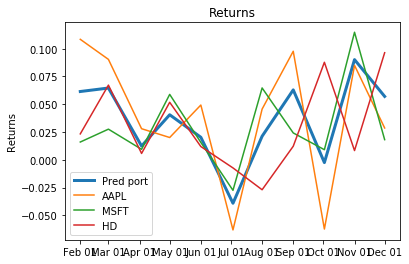

In [36]:
test_prediction=rfr.predict(test_features)#wi
test_returns=np.sum(df_rtrns_m.iloc[train_size:]*test_prediction,axis=1)

#from matplotlib.dates import DateFormatter
fig,ax=plt.subplots()#No se muy bien para que sirve hacer esto
plt.plot(test_returns,label='Pred port',linewidth=3.0)
plt.plot(df_rtrns_m['AAPL'].iloc[train_size:],label='AAPL')
plt.plot(df_rtrns_m['MSFT'].iloc[train_size:],label='MSFT')
plt.plot(df_rtrns_m['HD'].iloc[train_size:],label='HD')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#plt.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.title('Returns')
plt.ylabel('Returns')
plt.legend()
plt.show()

<b> Calculate hypothetical investment <b>

In [45]:
cash=1000
port_rtrns=[cash]

for r in test_returns:
    cash*=1+r
    port_rtrns.append(cash)

#calculate performance for AAPL
cash=1000
AAPL_rtrns=[cash]
for r in df_rtrns_m['AAPL'].iloc[train_size:]:
    cash*=1+r
    AAPL_rtrns.append(cash)
cash=1000    
MSFT_rtrns=[cash]
for r in df_rtrns_m['MSFT'].iloc[train_size:]:
    cash*=1+r
    MSFT_rtrns.append(cash)
cash=1000
HD_rtrns=[cash]
for r in df_rtrns_m['HD'].iloc[train_size:]:
    cash*=1+r
    HD_rtrns.append(cash)
    
print("Port returns:",(port_rtrns[-1]-port_rtrns[0])/port_rtrns[0])
print("AAPL returns:",(AAPL_rtrns[-1]-AAPL_rtrns[0])/AAPL_rtrns[0])

Port returns: 0.4560605266722068
AAPL returns: 0.49645778404672525


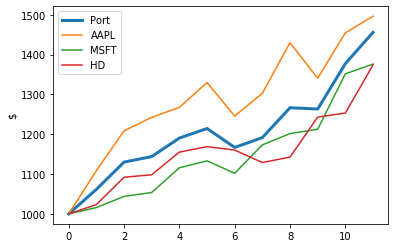

In [47]:
#Plot the results
plt.plot(port_rtrns,label='Port',linewidth=3.0)
plt.plot(AAPL_rtrns,label='AAPL')
plt.plot(MSFT_rtrns,label='MSFT')
plt.plot(HD_rtrns,label='HD')
plt.ylabel('$')
plt.legend()
plt.show()

<b> Add the grid parameter <b>

In [177]:
#from sklearn.model_selection import ParameterGrid
#from pprint import pprint
#To adjust the Algorithm best features
grid={'n_estimators':[200],'max_features':[0,1,2,3,4],'max_depth':[3,5]}
pprint(list(ParameterGrid(grid)))

[{'max_depth': 3, 'max_features': 0, 'n_estimators': 200},
 {'max_depth': 3, 'max_features': 1, 'n_estimators': 200},
 {'max_depth': 3, 'max_features': 2, 'n_estimators': 200},
 {'max_depth': 3, 'max_features': 3, 'n_estimators': 200},
 {'max_depth': 3, 'max_features': 4, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 0, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 1, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 2, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 3, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 4, 'n_estimators': 200}]


In [178]:
test_scores=[]
# Create a loop to check the grid parameters and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)#Unpacking the dictionary
    rfr.fit(train_features,train_targets)
    test_scores.append(rfr.score(train_features,train_targets))#R^2
    
# Find the best set of parameters
best_score_idxs=np.argmax(test_scores)
print(test_scores[best_score_idxs])
print(ParameterGrid(grid)[best_score_idxs])

ValueError: max_features must be in (0, n_features]